# DAFI's Random Field Module
This document shows the use of DAFI's random field module *dafi.random_field* to work with random fields. Particularly, the examples show how to generate samples and how to perform a modal decomposition.

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from dafi import random_field as rf

%matplotlib inline

## 1D Gaussian Process Example
First generate the mesh

In [2]:
ncells = 100
L = 1.0 
x = np.linspace(0.0, L, ncells)
dx = x[1] - x[0]

Next specify the mean and covariance. See the Covariance tutorial for details. We will take the mean field to be linear, the standard deviation to be proportional ($10\%$) to the mean value and a constant correlation length. The correlation kernel is the default square exponential.  

In [3]:
mean = 3*x + 0.1
cov = rf.covariance.generate_cov(stddev=0.1*mean, coords=x, length_scales=0.1*L)
cov_nan = rf.covariance.sparse_to_nan(cov)

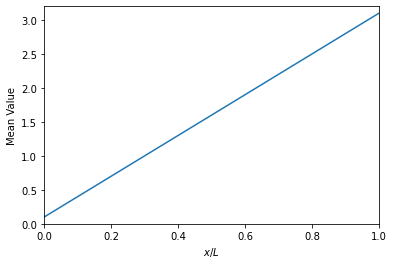

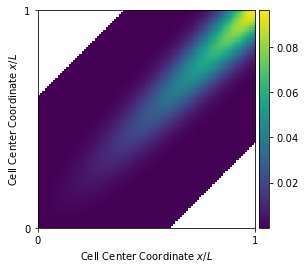

In [4]:
# PLOT
plt.figure()
plt.plot(x, mean)
plt.xlabel('$x/L$')
plt.ylabel('Mean Value')
plt.xlim([0,1])
plt.ylim([0,3.2])

fig, ax = plt.subplots()
im = ax.matshow(np.flipud(cov_nan), extent=[0,1,0,1], interpolation='none')
ax.xaxis.tick_bottom()
ax.set_xlabel('Cell Center Coordinate $x/L$')
ax.set_ylabel('Cell Center Coordinate $x/L$')
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

### Samples using Cholesky Decomposition
Now we will create samples using the Cholesky decomposition. You can see that near $x/L=1$ the variance is much larger than near $x/L=0$. Also notice the smoothness of the samples reflects the chosen correlation length.

This method uses the entire covariance matrix, which because of numerical error on very small eigenvalues can be not positive definite. For this reason a small perturbation is added to the diagonal and this can be controlled by the *eps* argument which has a default value of $1e-8$. This is often still not enough, in which case it is recommended to use a KL decomposition and sample using a subset of the eigenvectors. This will be illustrated later.  

In [5]:
nsamples=10
samples = rf.gp_samples_cholesky(cov=cov, nsamples=nsamples, mean=mean)

(0.0, 3.2)

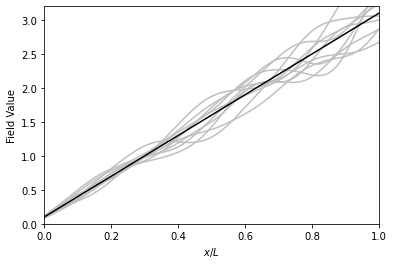

In [6]:
# plot
plt.figure()
plt.plot(x, samples, '-', color='0.75')
plt.plot(x, mean, 'k-')
plt.xlabel('$x/L$')
plt.ylabel('Field Value')
plt.xlim([0,1])
plt.ylim([0,3.2])

#### Discrepancy (zero mean)
Alternatively we can sample only the discrepancy (i.e. zero mean) by not specifying a mean.

(-1.0, 1.0)

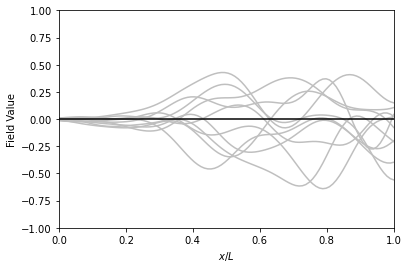

In [7]:
samples_disc = rf.gp_samples_cholesky(cov, nsamples)

# plot
plt.figure()
plt.plot(x, samples_disc, '-', color='0.75')
plt.plot(x, np.zeros(x.shape), 'k-')
plt.xlabel('$x/L$')
plt.ylabel('Field Value')
plt.xlim([0,1])
plt.ylim([-1,1])

### Karhunen-Loève (modal) decomposition
Instead of sampling from the entire covariance matrix, we will now do an eigen-decomposition and use a subset of the eigenvectors to sample the field. Note that for the correct eigendecomposition the weight field must be specified. The weight field corresponds to the volume (area/length in 2D/1D) of each cell. In general this is a 1D array, but since we are using a constant mesh we can specify a float. The *calc_kl_modes* function also accepts a number of modes argument (*nmodes*) in which case only the N modes corresponding to the N largest eigenvalues are returned. By default the modes are normalized (norm=1) but this can be changed by speciying *normalize=False*, in which case they will be weighted by the appropriate standard deviation. 

In [8]:
eig_vals, modes = rf.calc_kl_modes(cov, weight_field=dx)

#### Coverage of Variance
We will now plot the eigenvalues and calculate the cummulative coverage of the total variance. As can be seen, about $10$ eigenvalues can cover almost $100\%$ of the variance.

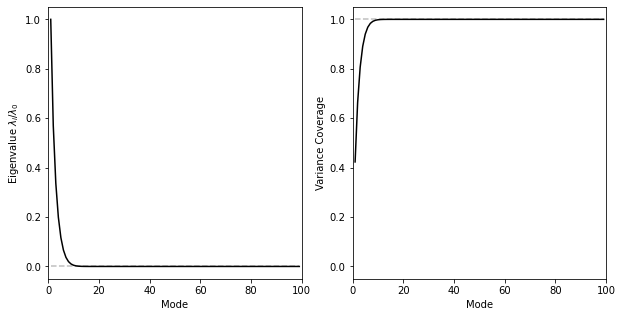

In [9]:
variance_coverage = rf.kl_coverage(cov, eig_vals, weight_field=dx)

# plot
imode = np.arange(len(eig_vals))+1
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(imode, np.zeros(eig_vals.shape), 'k--', color='0.75')
axs[0].plot(imode, eig_vals/eig_vals[0], 'k-')
axs[0].set(xlabel='Mode', ylabel='Eigenvalue $\lambda_i/\lambda_0$', xlim=[0, len(eig_vals)+1], ylim=[-0.05, 1.05]);
axs[1].plot(imode, np.ones(eig_vals.shape), 'k--', color='0.75')
axs[1].plot(imode, variance_coverage, 'k-')
axs[1].set(xlabel='Mode', ylabel='Variance Coverage', xlim=[0, len(eig_vals)+1], ylim=[-0.05, 1.05]);

We will keep only the first $10$ modes and use these to create samples. This subset of modes can also be used for reduced order modeling in the data assimilation or field inversion process (e.g. see diffusion tutorial). 

But first, lets look at the modes.

#### Visualizing the Modes

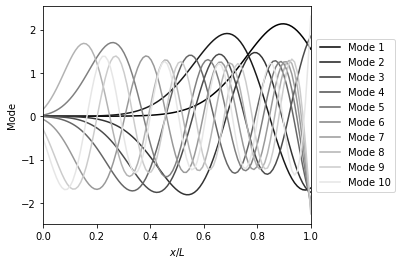

In [10]:
n = 10
fig, ax = plt.subplots()
for i in range(n):
    ax.plot(x, modes[:,i], color=plt.cm.gray(i/n), label=f'Mode {i+1}');
ax.set_xlabel('$x/L$')
ax.set_ylabel('Mode')
ax.set_xlim([0, 1])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


The larger modes can be seen to contain more spatial variance whereas the lower mode are smoother. 

All modes above have been normalized. We will now plot each mode with the appropriate variance captured by each. This can be done using the *scale_kl_modes* function. When we plot it we will see the quick reduction in magnitude for the higher modes. 

Also note that all modes have small magnitude near $x=0$. This is due to the small variance in this region we specified when constructing the covariance matrix.

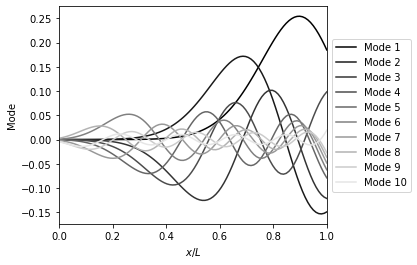

In [11]:
modes_scaled = rf.scale_kl_modes(eig_vals, modes)
    
n = 10
fig, ax = plt.subplots()
for i in range(n):
    ax.plot(x, modes_scaled[:,i], color=plt.cm.gray(i/n), label=f'Mode {i+1}');
ax.set_xlabel('$x/L$')
ax.set_ylabel('Mode')
ax.set_xlim([0, 1])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We can verify the norm of the modes using the *norm* function. 

In [12]:
imode = 5

print(f'norm mode {imode} (scaled):     {rf.norm(field=modes_scaled[:, imode], weight_field=dx):.6f}')
print(f'norm mode {imode} (normalized): {rf.norm(field=modes[:, imode], weight_field=dx):.6f}')

norm mode 5 (scaled):     0.030719
norm mode 5 (normalized): 1.000000


#### Sampling from the Modes
To create samples (for a gaussian process) we need to sum all the (scaled) modes after multiplying each by a realization of a standard normal. We also need to add the mean value (zeroth mode with zero variance). Here we use the *gp_samples_klmodes* function which reuqires having the modes already. There are other functions that take deirectly the covariance matrix and the number of modes or desired coverage and create the samples. 

(0.0, 3.2)

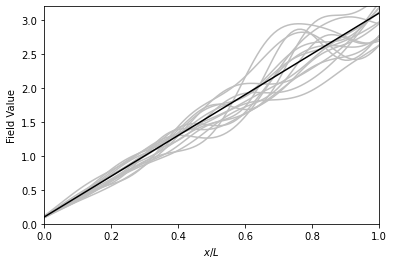

In [13]:
nreduced_modes = 10
nsamples = 15
samples = rf.gp_samples_klmodes(modes_scaled[:, :nreduced_modes], nsamples, mean=mean)

# plot
plt.figure()
plt.plot(x, samples, '-', color='0.75')
plt.plot(x, mean, 'k-')
plt.xlabel('$x/L$')
plt.ylabel('Field Value')
plt.xlim([0,1])
plt.ylim([0,3.2])

#### Projecting Onto the Modes
Another common task is projecting a field onto a subset of the modes. 
To showcase this, lets use one of our samples (created with 10 modes) and project it onto the first 3 modes. The projection will be the best estimate (orthogonal projection) of the field in this reduced space. 

In [14]:
field = samples[:, 0]
coeffs_projected = rf.project_kl(field-mean, modes_scaled[:, :nreduced_modes], weight_field=dx)
print(coeffs_projected)

[ 1.18066782 -0.53970218  0.49079241 -1.8059828   0.24277891 -1.80259405
 -1.86935588 -0.24572905  0.36403902  0.41765933]


To construct the projected field we need to scale each mode 1-3 with the coefficients above, and add them to the mean. This can be done with the *reconstruct_kl* function. If you increase the number of modes to use in the reconstruction you get closer to the truth. 

(0.0, 4.0)

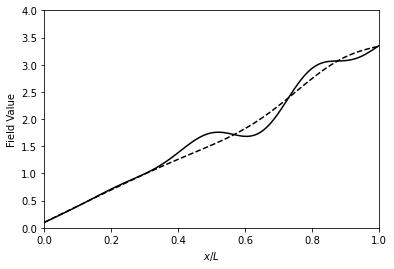

In [15]:
nproject = 3 # CHANGE THIS

field_projected = rf.reconstruct_kl(modes_scaled[:, :nproject], coeffs_projected[:nproject], mean)

# plot
plt.figure()
plt.plot(x, field, 'k-')
plt.plot(x, field_projected, 'k--')
plt.xlabel('$x/L$')
plt.ylabel('Field Value')
plt.xlim([0,1])
plt.ylim([0,4])

## 2D Gaussian Process Example
Here we will generate samples of a 2D field.

First let's create the mesh.

In [16]:
Lx = 1
Ly = 0.25
nxpoints = 50
nypoints = 25
ncells = nxpoints*nypoints

# areas
dx = Lx / nxpoints
dy = Ly / nypoints
dA = dx * dy

xpos, ypos = np.meshgrid(np.linspace(0, Lx, nxpoints), np.linspace(0, Ly, nypoints))
xpos = np.atleast_2d(xpos.ravel()).T
ypos = np.atleast_2d(ypos.ravel()).T
coords = np.hstack([xpos, ypos])

We choose the random field to have a constant mean field of $1.0$ and the covariance is square exponential with constant length scale of $0.1$ in both directions and constant standard deviation of $0.5$. 

In [17]:
mean = 1.0
cov = rf.covariance.generate_cov('sqrexp', stddev=1.0, coords=coords, length_scales=[0.1, 0.1])

We will create the samples using a single convenience function that will: 
* Do the KL decomposition
* Keep the required number of modes to account for $99\%$ of the variance
* Generate the samples

For plotting we will use a bilinear interpolation. 

In [18]:
nsamples = 4
samples, nmodes = rf.gp_samples_kl_coverage(cov, nsamples, dA, coverage=0.99, mean=mean, max_modes=100)
print(nmodes)

30


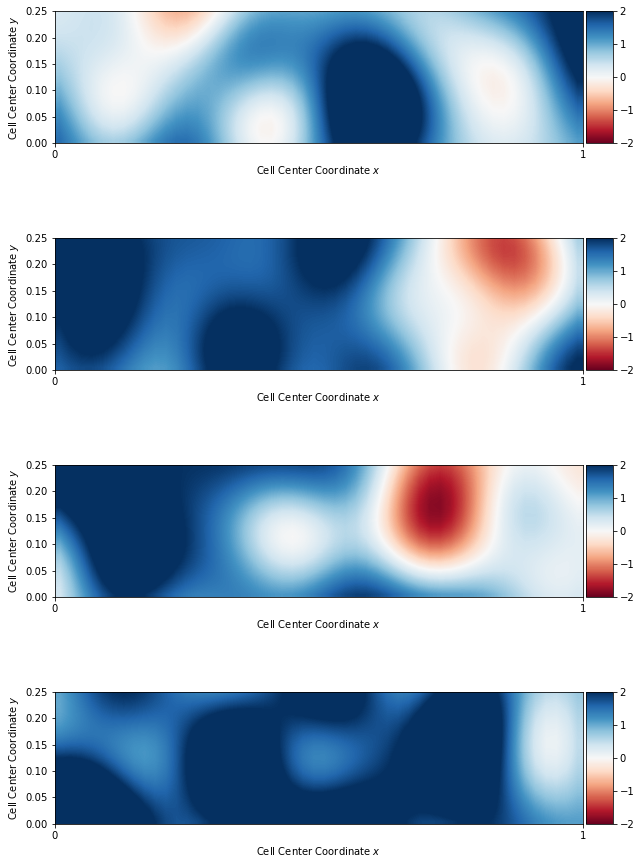

In [19]:
# plot
fig, axs = plt.subplots(nsamples, 1, figsize=(10, 4*nsamples))
for i in range(nsamples):
    im = axs[i].matshow(np.flipud(samples[:,i].reshape([nypoints,nxpoints])), extent=[0,Lx,0,Ly], interpolation='bilinear', vmin=-2.0, vmax=2.0, cmap='RdBu')
    axs[i].xaxis.tick_bottom()
    axs[i].set_xlabel('Cell Center Coordinate $x$')
    axs[i].set_ylabel('Cell Center Coordinate $y$')
    axs[i].axis('equal')
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)